In [ ]:
from modules.models import KdVBurgersPinn, create_dense_model, create_dense_model_Normalized, FourierFeatures
from modules.data import simulate_kdvburgers
from modules.plots import plot_KdV_model, plot_training_loss
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [ ]:

! git add KdVBDispersiveTail.ipynb
! git commit -m "KdV coefficients given to PINN were written in terms of IC coefficinets minus a delta term"
! git push origin main

[main 5495680] KdV coefficients given to PINN were written in terms of IC coefficinets minus a delta term
 1 file changed, 1 insertion(+), 1 deletion(-)
 rewrite PinnNew/KdVBDispersiveTail.ipynb (92%)
Enumerating objects: 7, done.
Counting objects: 100% (7/7), done.
Delta compression using up to 12 threads
Compressing objects: 100% (4/4), done.
Writing objects: 100% (4/4), 370.59 KiB | 8.82 MiB/s, done.
Total 4 (delta 2), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (2/2), completed with 2 local objects.
To https://github.com/naiaseh/Trunk.git
   bdb4e12..5495680  main -> main


In [ ]:
!git config --global user.name "Nadia Aiaseh"
!git config --global user.email "naiaseh@uwo.ca"


In [ ]:
from google.colab import drive # if in colab, first run this
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os # if in colab, second run this
os.chdir("/content/drive/MyDrive/Trunk/PinnNew")
print(os.getcwdb())

b'/content/drive/MyDrive/Trunk/PinnNew'


### Initial and boundary conditions

In [ ]:


delt = 0.5
alpha = 0.
beta = 0.7
gamma = 1.
c0 = 1.
k = 0.1
c = c0
phi = 0.
ampl = 3*c0/gamma
multiplier = c0/(beta*4)


def phi_function(tx):
    offset =  0.
    ksi = tx[:, 1:2]-c0*tx[:,0:1]+offset
    ampl = 3*c0/gamma
    multiplier = c0/(beta*4)
    u = ampl / tf.cosh(np.sqrt(multiplier)*ksi)**2
    u = tf.where(tf.math.is_nan(u), 0., u)
    return u




def boundary_function(tx):
    return phi*tf.ones_like(tx[:, 1:])


x_start =  -50.
length = 50.
t0 = 0.
time = 10.

tf.Tensor([7.7332803e-05], shape=(1,), dtype=float64)


Text(0, 0.5, 'u(x,t)')

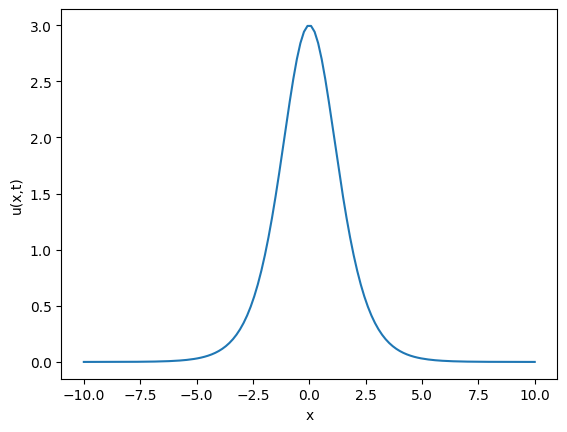

In [ ]:
# plotting the IC
N =  128
TIME = 0.
xt = np.linspace(-10,10,N).T

tt = np.zeros((N,1))
xt = xt.reshape(-1,1)

tt = tt.reshape(-1,1)
txy2 = np.stack([np.full(tt.shape, TIME),  xt ], axis=1)
txy3 = np.stack([np.full(tt.shape, time),  xt ], axis=1)
u2 = phi_function(txy2)
u2 = tf.reshape(u2, [xt.shape[0],xt.shape[1]])


plt.plot(xt, u2)

plt.xlabel('x')
plt.ylabel('u(x,t)')


### generating data

In [ ]:

 (tx_eqn, y_eqn), (tx_init, y_init), (tx_boundary, y_boundary) = simulate_kdvburgers(30_000, phi_function, boundary_function, x_start, length, t0, time, n_init = None, n_bnd = None, random_seed = 42, dtype=tf.float32)




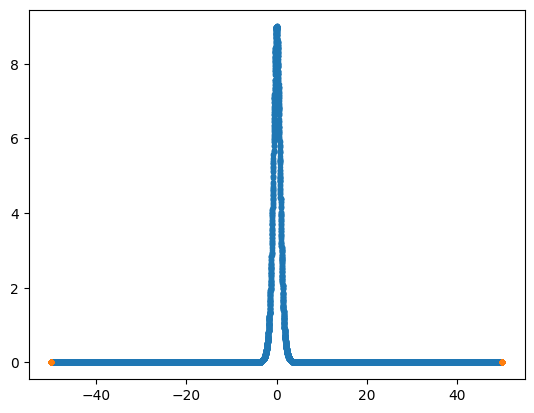

In [ ]:

plt.plot( tx_init[:,1:], phi_function(tx_init),'.')
plt.plot( tx_boundary[:,1:], y_boundary,'.')


In [ ]:
inputs = [tx_eqn, tx_init, tx_boundary]
outputs = [phi_function(tx_eqn), y_eqn, y_init, y_boundary]


### PINN initialization and training

In [ ]:
backbone = create_dense_model([32, 32, 32], activation='tanh', initializer='glorot_normal',\
    n_inputs=2, n_outputs=1)
pinn = KdVBurgersPinn(backbone, alpha=alpha, beta=beta-delt/(4*multiplier), gamma=gamma-3*delt/ampl,c=0., loss_residual_weight = 1.) # coefficients offset by a small amount
a0 = 1e-3
decay_step = 1000
rate = 0.95
scheduler = tf.keras.optimizers.schedules.ExponentialDecay(a0, decay_steps= decay_step, decay_rate= rate)
optimizer = tf.keras.optimizers.Adam(learning_rate=scheduler, clipnorm=1.)
pinn.compile(optimizer=optimizer)

In [ ]:

history = pinn.fit_custom(inputs, outputs, epochs = 50_000, print_every = 500)
# history = pinn.fit(inputs, outputs, batch_size = 30000, epochs = 5000)

Epoch 0, Loss Residual: 0.0033753295, Loss Initial: 1.0516676903, Loss Boundary: 0.0417369492, MAE: 0.3891323507
Epoch 500, Loss Residual: 0.0069508119, Loss Initial: 0.0010145167, Loss Boundary: 0.0000403353, MAE: 0.3125653863
Epoch 1000, Loss Residual: 0.0020876741, Loss Initial: 0.0000774410, Loss Boundary: 0.0000046016, MAE: 0.3022224903
Epoch 1500, Loss Residual: 0.0010440624, Loss Initial: 0.0000372785, Loss Boundary: 0.0000027774, MAE: 0.2964412570
Epoch 2000, Loss Residual: 0.0005570868, Loss Initial: 0.0000151290, Loss Boundary: 0.0000016913, MAE: 0.2907767296
Epoch 2500, Loss Residual: 0.0003619872, Loss Initial: 0.0000079925, Loss Boundary: 0.0000011679, MAE: 0.2883954942
Epoch 3000, Loss Residual: 0.0002617069, Loss Initial: 0.0000078332, Loss Boundary: 0.0000025894, MAE: 0.2868540287
Epoch 3500, Loss Residual: 0.0004145139, Loss Initial: 0.0000776076, Loss Boundary: 0.0000819514, MAE: 0.2940582037
Epoch 4000, Loss Residual: 0.0002397806, Loss Initial: 0.0000408953, Loss Bo

### Plots

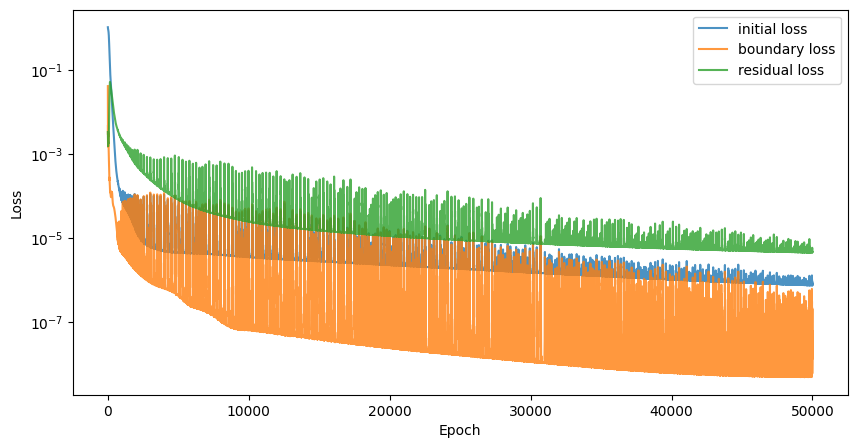

In [ ]:
 history2 = {k: history[k] for k in ('loss_total', 'loss_residual', 'loss_initial', 'loss_boundary')}

plot_training_loss(history2, y_scale='log')



Text(0, 0.5, 'MAE')

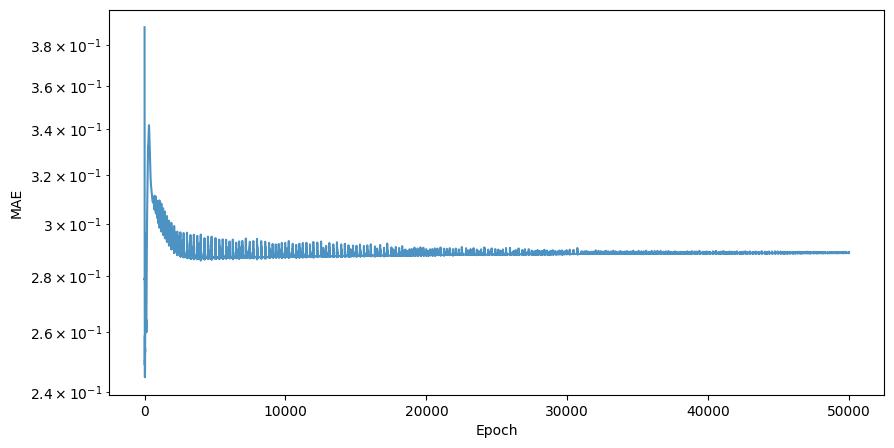

In [ ]:
plt.figure(figsize=(10, 5), dpi = 100)
plt.yscale('log')
plt.plot(history['mean_absolute_error'], label='mean absolute error', alpha = 0.8)
plt.xlabel('Epoch')
plt.ylabel('MAE')

1/1 [==============================] - 0s 17ms/step


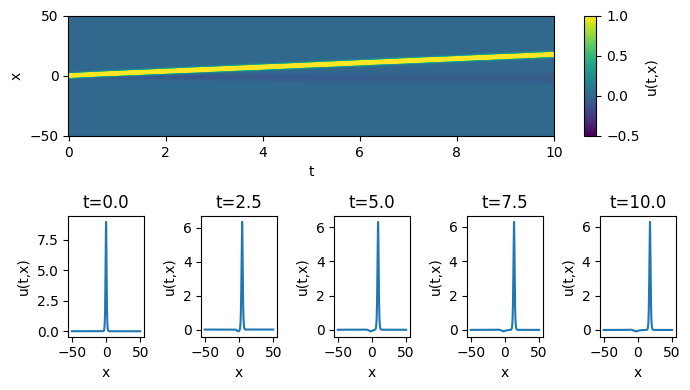

In [ ]:
plot_KdV_model(pinn.backbone, x_start,length, time, -0.5, 1., t0 = t0, save_path = None, show=True)

1000/1000 [==============================] - 1s 1ms/step


Text(0, 0.5, '$t$')

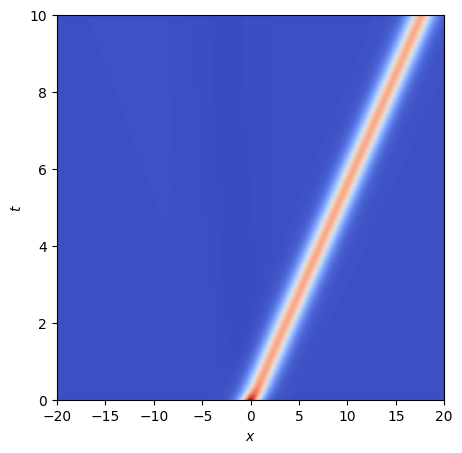

In [ ]:
    from matplotlib.gridspec import GridSpec

    num_test_samples = 1000
    t_flat = np.linspace(t0, time, num_test_samples)
    x_flat = np.linspace(-20, 20, num_test_samples)
    t, x = np.meshgrid(t_flat, x_flat)
    tx = np.stack([t.flatten(), x.flatten()], axis=-1) #
    u = pinn.backbone.predict(tx, batch_size=num_test_samples)
    u = u.reshape(t.shape)

    # plot u(t,x) distribution as a color-map
    fig = plt.figure(figsize=(5,5))
    gs = GridSpec(1, 1)
    plt.subplot(gs[:, :])
    plt.pcolormesh(x, t, u, cmap = 'coolwarm', shading='auto')
    plt.xlabel('$x$')
    plt.ylabel('$t$')
    # cbar = plt.colorbar(pad=0.05, aspect=10, locationm = None)
    # cbar.set_label('u(t,x)')
    # cbar.mappable.set_clim(-1, 3)
    # plot u(t=const, x) cross-sections

In [ ]:
def plot_snapshots(timeList,num_test_samples = 1000, phi_function = phi_function, pinn = pinn):
    x_flat = np.linspace(x_start, length, num_test_samples)
    t_flat = np.linspace(t0, time, num_test_samples)
    x_flat = tf.convert_to_tensor(x_flat)
    t_flat = tf.convert_to_tensor(t_flat)

    dt=time/(num_test_samples-1)
    t_cross_sections = timeList
    for i, t_cs in enumerate(t_cross_sections):
        tx = np.stack([np.full(t_flat.shape, t_cs), x_flat], axis=-1)
        print(tx.shape)
        u = pinn.backbone.predict(tx, batch_size=num_test_samples)
        plt.plot(x_flat, u, label = 'prediction at time {}'.format(t_cs))

        plt.xlabel('x')
        plt.ylabel('u(t,x)')

    return

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

# Set up meshgrid
N = 1000
xspace = np.linspace(x_start, length, N + 1)
tspace = np.linspace(t0, time, N + 1)
T, X = np.meshgrid(tspace, xspace)
Xgrid = np.vstack([T.flatten(),X.flatten()]).T

# Determine predictions of u(t, x)

upred = pinn.backbone.predict(Xgrid)

# Reshape upred
U = upred.reshape(N+1,N+1)

# Surface plot of solution u(t,x)

31313/31313 [==============================] - 37s 1ms/step


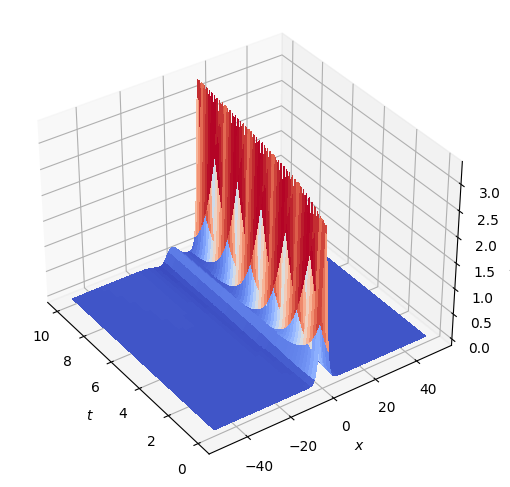

In [ ]:
from matplotlib import cm
from matplotlib.colors import LightSource
from matplotlib.ticker import LinearLocator
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111, projection='3d')


ax.plot_surface(T, X, U, cmap='coolwarm', antialiased = False, linewidth=0);
ax.view_init(35,-35,0)
# ax.view_init(90,-90,0)
ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.set_zlabel('$u(x,t)$')
ax.invert_xaxis()
# ax.set_title('Solution of KdV equation');



(1000, 2)
1/1 [==============================] - 0s 19ms/step
(1000, 2)
1/1 [==============================] - 0s 18ms/step
(1000, 2)
1/1 [==============================] - 0s 18ms/step
(1000, 2)
1/1 [==============================] - 0s 19ms/step
(1000, 2)
1/1 [==============================] - 0s 17ms/step
(1000, 2)
1/1 [==============================] - 0s 18ms/step
(1000, 2)
1/1 [==============================] - 0s 18ms/step
(1000, 2)
1/1 [==============================] - 0s 18ms/step
(1000, 2)
1/1 [==============================] - 0s 18ms/step
(1000, 2)
1/1 [==============================] - 0s 17ms/step
(1000, 2)
1/1 [==============================] - 0s 18ms/step


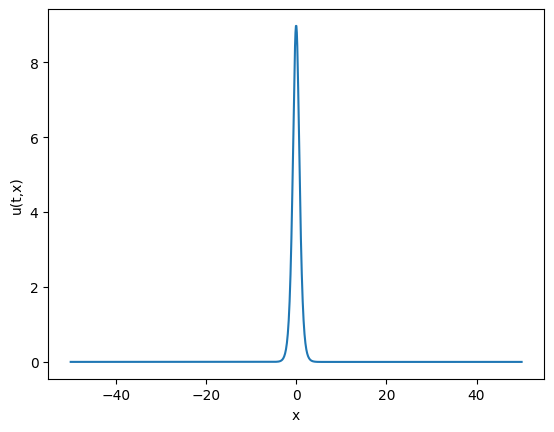

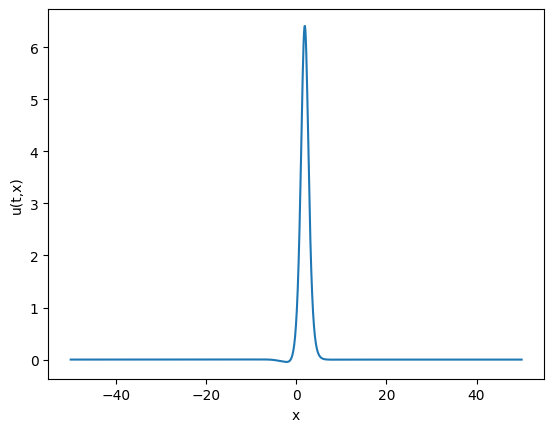

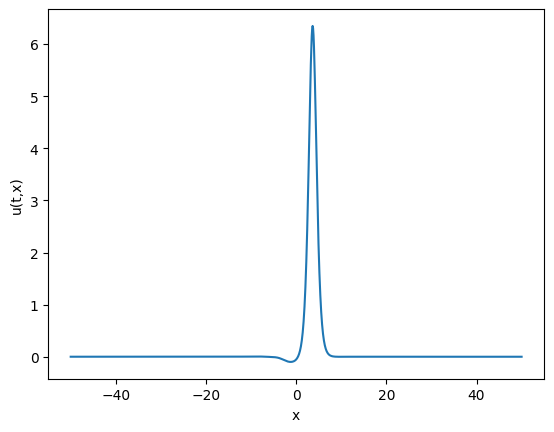

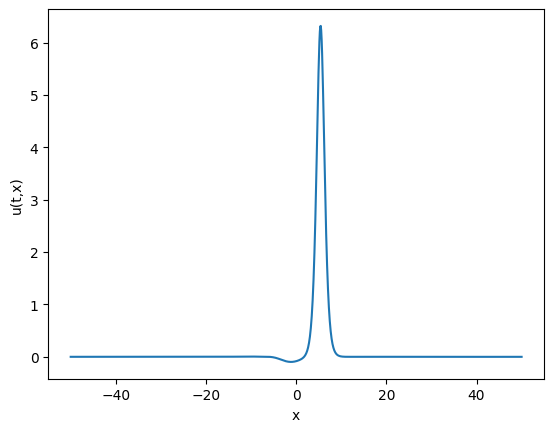

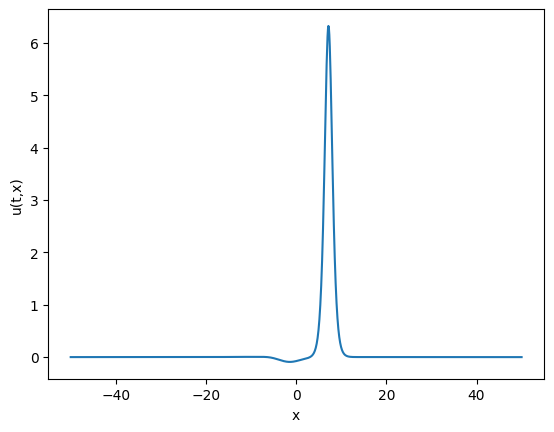

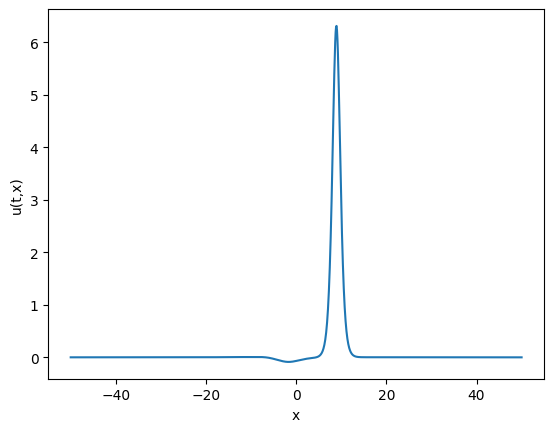

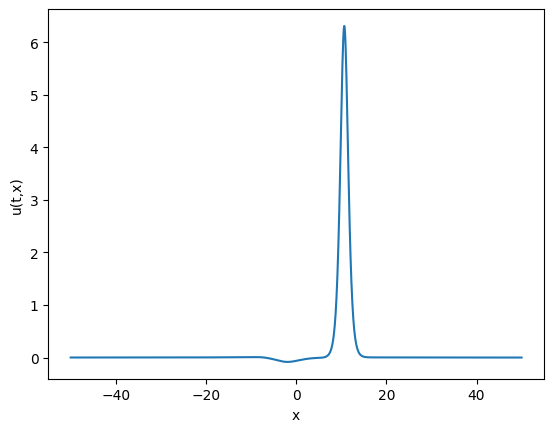

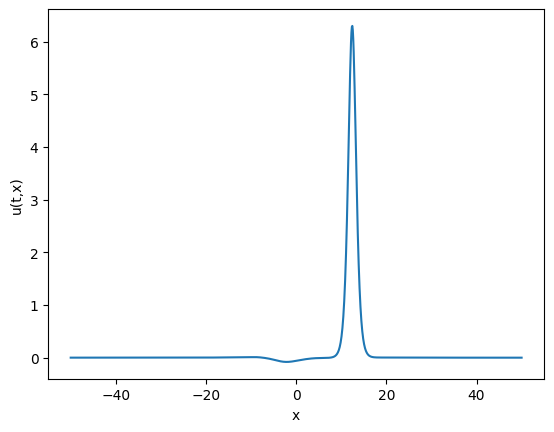

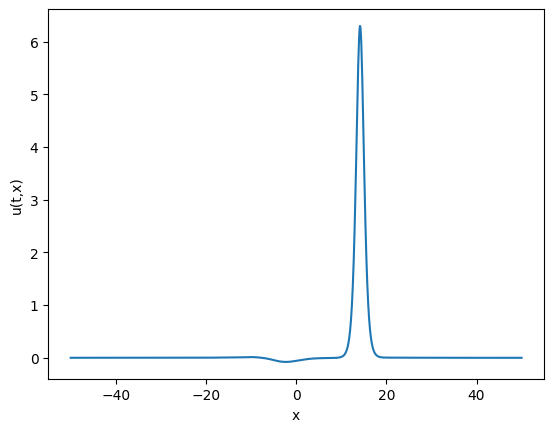

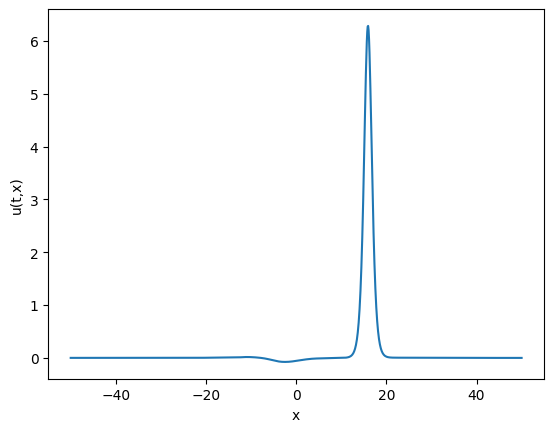

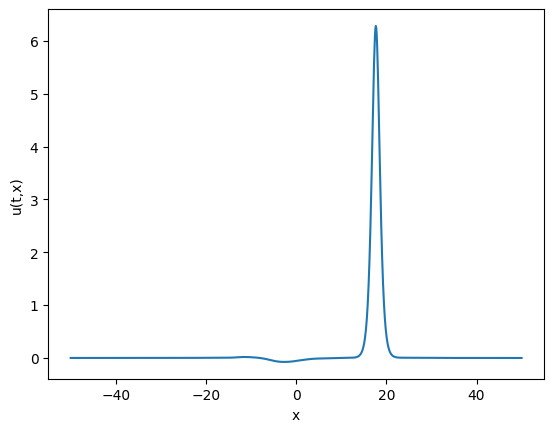

In [ ]:
step = 1
T = np.arange(t0,time+step, step)
for inde, Tt in enumerate(T):
  plt.figure()
  plot_snapshots([Tt], phi_function = phi_function, pinn = pinn)

  # plt.savefig(str(os.getcwdb())[2:-1]+"/FinalPictures/KdVBTwoSolitonAlpha0-1/fr"+str(inde)+".pdf", format="pdf", bbox_inches="tight")